<h2 align=center> Facial Expression Recognition with Keras</h2>

### Import Libraries

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


### Plot Sample Image

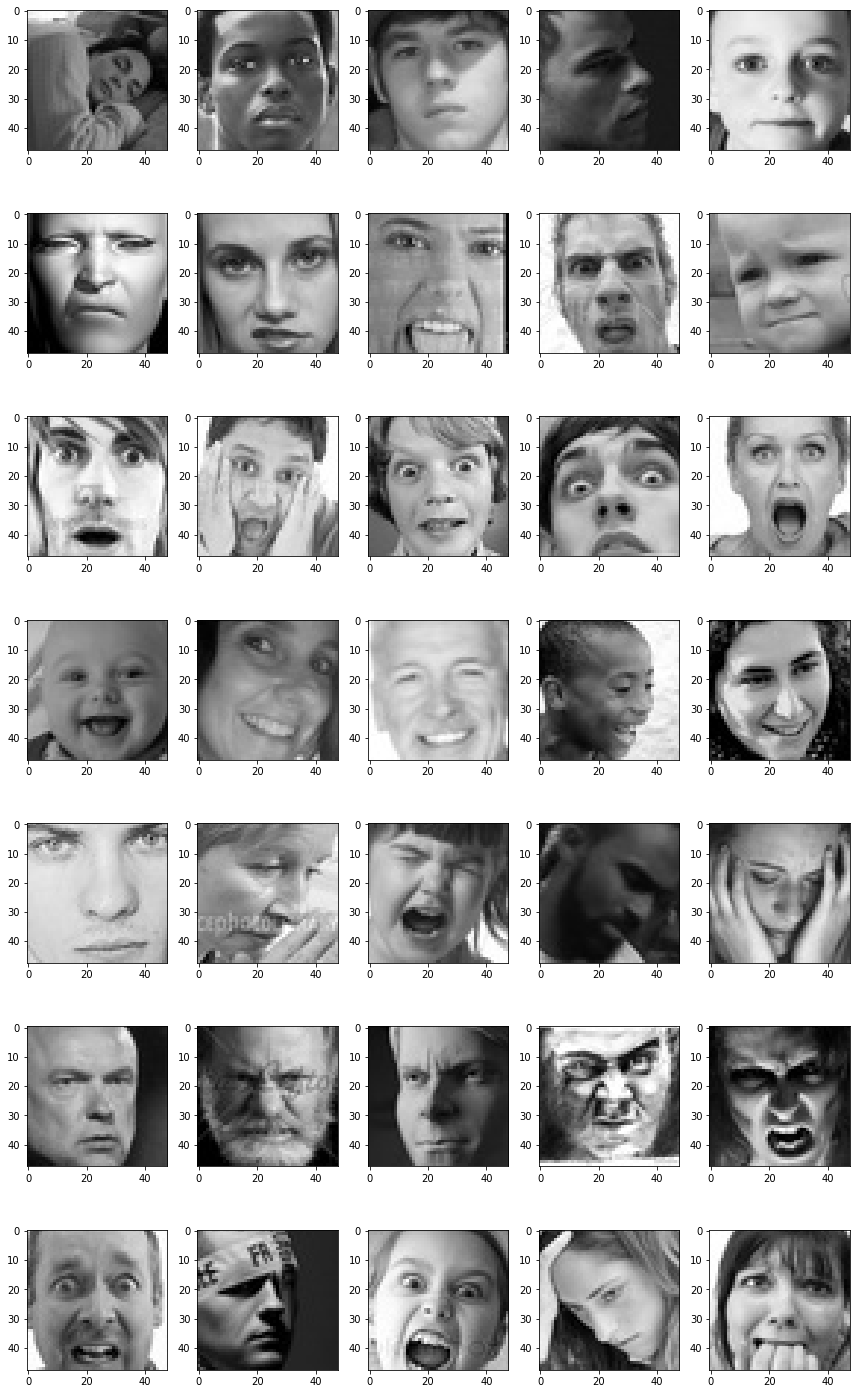

In [4]:
utils.datasets.fer.plot_example_images(plt).show()

In [5]:
for d in os.listdir('train/'):
    print(str(len(os.listdir('train/'+d)))+' '+d+' images')

4965 neutral images
436 disgust images
3171 surprise images
7215 happy images
4830 sad images
3995 angry images
4097 fear images


### Generate Training and Validation Batches

In [7]:
img_size = 48
batch_size = 64

traindatagen = ImageDataGenerator(horizontal_flip=True)
traingen = traindatagen.flow_from_directory('train/',
                                           target_size = (img_size,img_size),
                                           color_mode = 'grayscale',
                                           batch_size = batch_size,
                                           class_mode = 'categorical',
                                           shuffle = True)

valdatagen = ImageDataGenerator(horizontal_flip=True)
valgen = traindatagen.flow_from_directory('test/',
                                           target_size = (img_size,img_size),
                                           color_mode = 'grayscale',
                                           batch_size = batch_size,
                                           class_mode = 'categorical',
                                           shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [12]:
model = Sequential()

#layer 1
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 2
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 3
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 4
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 128)      

### Train and Evaluate Model

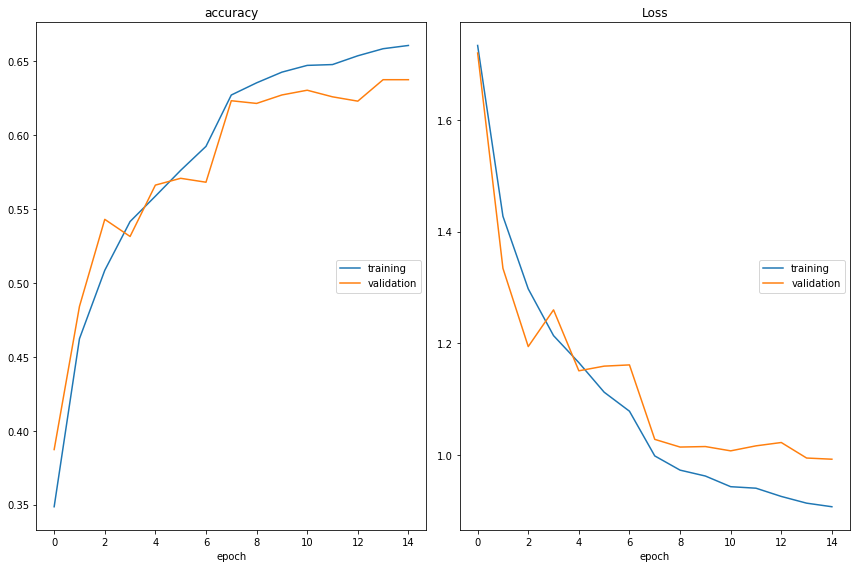

accuracy
	training         	 (min:    0.349, max:    0.661, cur:    0.661)
	validation       	 (min:    0.387, max:    0.637, cur:    0.637)
Loss
	training         	 (min:    0.908, max:    1.733, cur:    0.908)
	validation       	 (min:    0.993, max:    1.719, cur:    0.993)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 648s 1s/step - loss: 0.9078 - accuracy: 0.6606 - val_loss: 0.9929 - val_accuracy: 0.6374


In [13]:
epochs = 15
steps_per_epoch = traingen.n//traingen.batch_size
validation_steps = valgen.n//valgen.batch_size

checkpoint = ModelCheckpoint('model_weights.h5',monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                             patience = 2,
                             min_lr=0.000001,
                             mode='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = traingen,
                   steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=valgen,
                   validation_steps=validation_steps,
                   callbacks=callbacks)


### Represent Model as JSON String

In [15]:
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)